<a href="https://colab.research.google.com/github/dojian/MLproject/blob/main/Edge_detector_with_centroid_graph_nn_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Created on Nov 26 2023
Updated on Dec 02 2023
@author: dojian
"""

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 9.0 MB/s eta 0:00:00


In [ ]:
# Import libraries

import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, atan2, pi
from PIL import Image, ImageDraw
from ultralytics import YOLO
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def canny_edge_detector(input_image):
    input_pixels = input_image.load()
    width = input_image.width
    height = input_image.height

    # Transform the image to grayscale
    grayscaled = compute_grayscale(input_pixels, width, height)

    # Blur it to remove noise
    blurred = compute_blur(grayscaled, width, height)

    # Compute the gradient
    gradient, direction = compute_gradient(blurred, width, height)

    # Non-maximum suppression
    filter_out_non_maximum(gradient, direction, width, height)

    # Filter out some edges
    keep = filter_strong_edges(gradient, width, height, 20, 25)

    return keep


def compute_grayscale(input_pixels, width, height):
    grayscale = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            pixel = input_pixels[x, y]
            grayscale[x, y] = (pixel[0] + pixel[1] + pixel[2]) / 3
    return grayscale


def compute_blur(input_pixels, width, height):
    # Keep coordinate inside image
    clip = lambda x, l, u: l if x < l else u if x > u else x

    # Gaussian kernel
    kernel = np.array([
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256]
    ])

    # Middle of the kernel
    offset = len(kernel) // 2

    # Compute the blurred image
    blurred = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            acc = 0
            for a in range(len(kernel)):
                for b in range(len(kernel)):
                    xn = clip(x + a - offset, 0, width - 1)
                    yn = clip(y + b - offset, 0, height - 1)
                    acc += input_pixels[xn, yn] * kernel[a, b]
            blurred[x, y] = int(acc)
    return blurred


def compute_gradient(input_pixels, width, height):
    gradient = np.zeros((width, height))
    direction = np.zeros((width, height))
    for x in range(width):
        for y in range(height):
            if 0 < x < width - 1 and 0 < y < height - 1:
                magx = input_pixels[x + 1, y] - input_pixels[x - 1, y]
                magy = input_pixels[x, y + 1] - input_pixels[x, y - 1]
                gradient[x, y] = sqrt(magx**2 + magy**2)
                direction[x, y] = atan2(magy, magx)
    return gradient, direction


def filter_out_non_maximum(gradient, direction, width, height):
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            angle = direction[x, y] if direction[x, y] >= 0 else direction[x, y] + pi
            rangle = round(angle / (pi / 4))
            mag = gradient[x, y]
            if ((rangle == 0 or rangle == 4) and (gradient[x - 1, y] > mag or gradient[x + 1, y] > mag)
                    or (rangle == 1 and (gradient[x - 1, y - 1] > mag or gradient[x + 1, y + 1] > mag))
                    or (rangle == 2 and (gradient[x, y - 1] > mag or gradient[x, y + 1] > mag))
                    or (rangle == 3 and (gradient[x + 1, y - 1] > mag or gradient[x - 1, y + 1] > mag))):
                gradient[x, y] = 0


def filter_strong_edges(gradient, width, height, low, high):
    # Keep strong edges
    keep = set()
    for x in range(width):
        for y in range(height):
            if gradient[x, y] > high:
                keep.add((x, y))

    # Keep weak edges next to a pixel to keep
    lastiter = keep
    while lastiter:
        newkeep = set()
        for x, y in lastiter:
            for a, b in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
                if gradient[x + a, y + b] > low and (x+a, y+b) not in keep:
                    newkeep.add((x+a, y+b))
        keep.update(newkeep)
        lastiter = newkeep

    return list(keep)


class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
class Data_Loader():

    def __init__(self, data_file_path, label_file_path, n_images, chart_type):
        self.data_file_path = data_file_path
        self.label_file_path = label_file_path
        self.n_images = n_images
        self.chart_type = chart_type  # Added chart_type as an attribute

    def load_image_data(self):
        X = []
        Y = []

        for file in os.listdir(self.data_file_path):
            file_path = os.path.join(self.data_file_path, file)

            if file.endswith('.jpg'):
                img_annotations = self.__load_annotations(file)

                # Check if annotations exist and if chart-type matches self.chart_type
                if img_annotations is not None and img_annotations.get('chart-type') == self.chart_type:
                    Y.append(img_annotations)
                    img = cv2.imread(file_path)
                    X.append(img)

                # Stop if enough images are loaded
                if len(X) >= self.n_images:
                    return X, Y

        return X, Y

    def __load_annotations(self, image_file_name):
        file_name = image_file_name.split('.jpg')[0]
        json_file_name = file_name + '.json'
        json_file_path = os.path.join(self.label_file_path, json_file_name)

        if os.path.isfile(json_file_path):
            with open(json_file_path) as f:
                return json.load(f)

        else:
            return None

In [ ]:
#Load data from Kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"angel80423","key":"f5a347582d10b1f9f45bc7bb61ab390b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c benetech-making-graphs-accessible

 97% 953M/982M [00:08<00:00, 128MB/s]
100% 982M/982M [00:08<00:00, 122MB/s]


In [ ]:
!unzip -q benetech-making-graphs-accessible.zip -d ./

In [ ]:
data_file_path = '/content/train/images'
label_file_path = '/content/train/annotations'

In [ ]:
#YOLO (You Only Look Once) is a popular deep learning algorithm used for real-time object detection
model = YOLO('yolov8n.pt')
#Selective Search is a technique that tries to identify potential bounding boxes or “regions of
#interest” in an image where objects might be located.
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


100%|██████████| 6.23M/6.23M [00:00<00:00, 62.9MB/s]


In [ ]:
n_images = 7000
chart_type='scatter'

# Load in raw data
X_raw, Y_raw = Data_Loader(data_file_path,
                           label_file_path, n_images,chart_type).load_image_data()


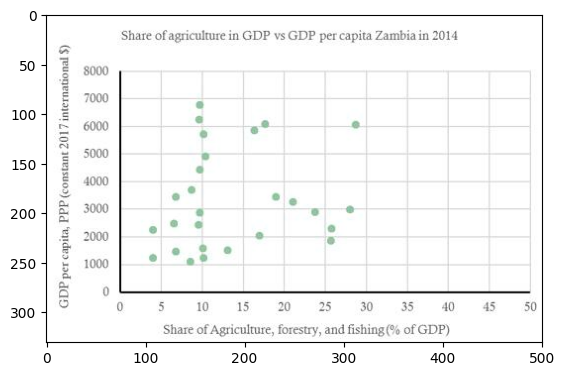

In [ ]:
plt.imshow(X_raw[0])

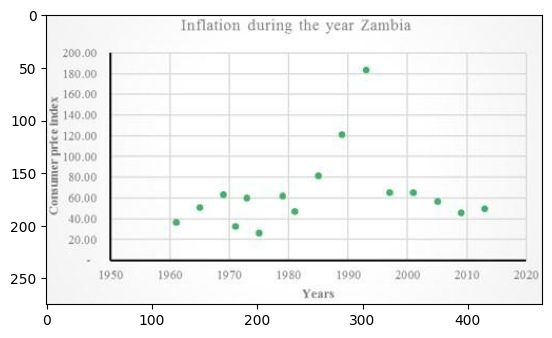

In [ ]:
plt.imshow(X_raw[1])

In [ ]:
#Process labels: make scatters saved as an array of (x,y) points

def process_labels(Y_raw):
    Y_processed = []
    for annotation in Y_raw:
        # Extract (x,y) for each point from annotation
        data_series = annotation['data-series']
        points = [(point['x'], point['y']) for point in data_series]
        Y_processed.append(points)

    return np.array(Y_processed)

Y_processed =process_labels(Y_raw)

<ipython-input-101-6886b0e1c1f2>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Y_processed)


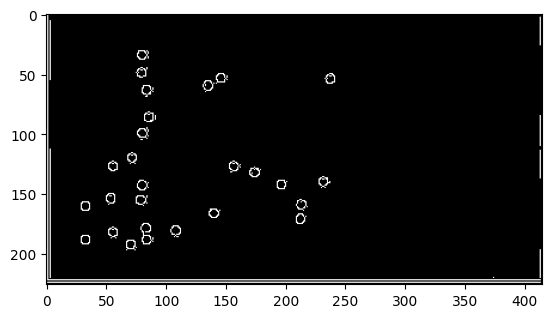

In [ ]:
train_images=[]
train_labels=[]
for index,image in enumerate(X_raw[0:1]):
      plot_bb = Y_raw[index]["plot-bb"]
      X_cropped = image[plot_bb["y0"]:plot_bb["y0"] + plot_bb["height"],
                          plot_bb["x0"]:plot_bb["x0"] + plot_bb["width"]]

      input_image = Image.fromarray(X_cropped)

      output_image = Image.new("RGB", input_image.size)
      draw = ImageDraw.Draw(output_image)
      edges = canny_edge_detector(input_image)
      for x, y in canny_edge_detector(input_image):
          draw.point((x, y), (255, 255, 255))

      plt.imshow(output_image)

In [ ]:
for index, image_array in enumerate(X_raw[0:1]):  # Only process the first image for now
    # Convert the numpy array to a PIL Image for processing with the edge detector
    image = Image.fromarray(image_array)
    edges = canny_edge_detector(image)

    # Convert the edge points back to an image where edges are white and the background is black
    edge_image = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(edge_image)
    for x, y in edges:
        draw.point((x, y), 255)

    # Convert the edge image to a format compatible with OpenCV
    edge_image_np = np.array(edge_image)

    # Find contours of the scatter plot points
    contours, _ = cv2.findContours(edge_image_np, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the centroids of the contours
    points = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            points.append((cX, cY))

    # The variable 'points' now contains the centroids of the contours
    print(points)

[(276, 322), (277, 322), (228, 322), (229, 322), (355, 320), (355, 321), (175, 319), (170, 321), (177, 320), (183, 319), (183, 316), (179, 319), (171, 319), (401, 317), (397, 321), (405, 320), (406, 317), (403, 317), (400, 316), (399, 315), (379, 316), (383, 320), (382, 314), (378, 314), (346, 319), (344, 321), (348, 317), (291, 319), (294, 323), (286, 323), (284, 320), (296, 317), (291, 319), (299, 317), (133, 318), (143, 322), (146, 321), (143, 318), (140, 317), (134, 320), (121, 317), (127, 316), (390, 317), (390, 318), (390, 314), (366, 318), (368, 322), (362, 319), (364, 319), (368, 318), (371, 313), (326, 312), (321, 319), (309, 323), (310, 321), (320, 319), (318, 318), (311, 319), (332, 319), (329, 320), (336, 319), (318, 318), (306, 318), (308, 313), (255, 318), (238, 323), (265, 322), (246, 322), (239, 321), (265, 319), (250, 319), (270, 319), (253, 317), (244, 317), (267, 316), (207, 319), (197, 323), (223, 321), (203, 320), (197, 320), (196, 318), (223, 318), (197, 317), (15

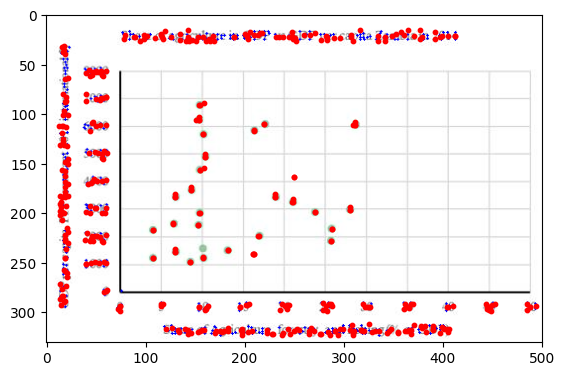

In [ ]:
# Now, let's plot the centroids on the original image
# Extract x and y coordinates from the points
x_coords = [x for x, y in points]
y_coords = [y for x, y in points]

# Display the original image
plt.imshow(image_array, cmap='gray')

# Overlay the centroids
plt.scatter(x_coords, y_coords, c='red', s=10)  # Red color, small dot size

# Show the plot with centroids
plt.show()